In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pyspark

In [3]:
import configparser  # class which implements a user customized basic configuration

In [4]:
import boto3  # AWS SDK for Python --> configure and manage AWS services (EC2, S3)

In [5]:
import os  # Operations on the OS

os.name

'posix'

In [6]:
from PIL import Image

In [7]:
import findspark

findspark.init()

## AWS login and S3 read check

In [8]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read("/home/ubuntu/.aws/credentials")
access_id = config.get(aws_profile, "aws_access_key_id")
access_key = config.get(aws_profile, "aws_secret_access_key")

In [9]:
session = boto3.Session(aws_access_key_id=access_id, aws_secret_access_key=access_key,)

In [10]:
s3 = session.resource("s3")
bucket = s3.Bucket("p08oc")
obj = bucket.Object(key="5_classes_5_images/Apple/2_100.jpg")
response = obj.get()
file_stream = response[u"Body"]
im = Image.open(file_stream)
im = im.resize((224, 224))
im_arr = np.asarray(im)

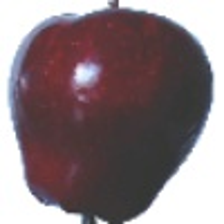

In [11]:
im

## Pyspark

In [12]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.master("local")
    .appName("APP_P08")  # Application name. This will appear in the UI and in log data.
    .config(
        "spark.driver.memory", "16g"
    )  # Amount of memory to use for the driver process / default 1g
    .config(
        "spark.executor.memory", "16g"
    )  # Amount of memory to use per executor process / default 1g
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/18 23:34:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
sc = spark.sparkContext

"sc = spark.sparkContext" permet d'instancier un objet de typeSparkContext, qui gère les propriétés globales de l'application (telles que le niveau de logging ou le niveau de parallélisation par défaut).

In [14]:
spark

In [15]:
paths = []
for file in bucket.objects.all():
    if file.key.split("/")[0] == "5_classes_5_images":
        paths.append(file.key)

In [16]:
rdd_paths = sc.parallelize(
    paths
)  # Distribute a local Python collection to form an Resilient Distributed Datasets (RDD).

A RDD is a fundamental data structure of PySpark, It is an immutable distributed collection of objects. Each dataset in RDD is divided into logical partitions, which may be computed on different nodes of the cluster.

In [17]:
rddCollect = (
    rdd_paths.collect()
)  # Return a list that contains all of the elements in the RDD
print("Number of Partitions: " + str(rdd_paths.getNumPartitions()))
print("--" * 5)
print("Action: First element: " + str(rdd_paths.first()))
print("--" * 5)
print(rddCollect)

Number of Partitions: 1
----------
Action: First element: 5_classes_5_images/Apple/2_100.jpg
----------
['5_classes_5_images/Apple/2_100.jpg', '5_classes_5_images/Apple/39_100.jpg', '5_classes_5_images/Apple/4_100.jpg', '5_classes_5_images/Apple/70_100.jpg', '5_classes_5_images/Apple/73_100.jpg', '5_classes_5_images/Avocado/45_100.jpg', '5_classes_5_images/Avocado/52_100.jpg', '5_classes_5_images/Avocado/57_100.jpg', '5_classes_5_images/Avocado/r_77_100.jpg', '5_classes_5_images/Avocado/r_7_100.jpg', '5_classes_5_images/Banana/110_100.jpg', '5_classes_5_images/Banana/168_100.jpg', '5_classes_5_images/Banana/86_100.jpg', '5_classes_5_images/Banana/r2_95_100.jpg', '5_classes_5_images/Banana/r_25_100.jpg', '5_classes_5_images/Carambula/147_100.jpg', '5_classes_5_images/Carambula/86_100.jpg', '5_classes_5_images/Carambula/r_188_100.jpg', '5_classes_5_images/Carambula/r_234_100.jpg', '5_classes_5_images/Carambula/r_311_100.jpg', '5_classes_5_images/Cauliflower/20_100.jpg', '5_classes_5_imag

In [18]:
from pyspark.sql import Row

In [19]:
row_rdd_paths = rdd_paths.map(lambda x: Row(x))

In [20]:
rddCollect = row_rdd_paths.collect()
print("Number of Partitions: " + str(row_rdd_paths.getNumPartitions()))
print("--" * 5)
print("Action: First element: " + str(row_rdd_paths.first()))
print("--" * 5)
print(rddCollect)

Number of Partitions: 1
----------
Action: First element: <Row('5_classes_5_images/Apple/2_100.jpg')>
----------
[<Row('5_classes_5_images/Apple/2_100.jpg')>, <Row('5_classes_5_images/Apple/39_100.jpg')>, <Row('5_classes_5_images/Apple/4_100.jpg')>, <Row('5_classes_5_images/Apple/70_100.jpg')>, <Row('5_classes_5_images/Apple/73_100.jpg')>, <Row('5_classes_5_images/Avocado/45_100.jpg')>, <Row('5_classes_5_images/Avocado/52_100.jpg')>, <Row('5_classes_5_images/Avocado/57_100.jpg')>, <Row('5_classes_5_images/Avocado/r_77_100.jpg')>, <Row('5_classes_5_images/Avocado/r_7_100.jpg')>, <Row('5_classes_5_images/Banana/110_100.jpg')>, <Row('5_classes_5_images/Banana/168_100.jpg')>, <Row('5_classes_5_images/Banana/86_100.jpg')>, <Row('5_classes_5_images/Banana/r2_95_100.jpg')>, <Row('5_classes_5_images/Banana/r_25_100.jpg')>, <Row('5_classes_5_images/Carambula/147_100.jpg')>, <Row('5_classes_5_images/Carambula/86_100.jpg')>, <Row('5_classes_5_images/Carambula/r_188_100.jpg')>, <Row('5_classes_5_i

#### From RDD to Dataframe

In [21]:
images_df = spark.createDataFrame(row_rdd_paths, ["path"])

In [22]:
images_df.show(3)

+--------------------+
|                path|
+--------------------+
|5_classes_5_image...|
|5_classes_5_image...|
|5_classes_5_image...|
+--------------------+
only showing top 3 rows



In [23]:
images_df.persist(pyspark.StorageLevel.DISK_ONLY)

DataFrame[path: string]

Spark Persist is an optimization technique for iterative and interactive Spark applications to improve the performance of Jobs. <br>
With "persist", each node stores its partitioned data in memory and reuses them in other actions on that dataset. <br> Spark’s persisted data on nodes are fault-tolerant meaning if any partition of a Dataset is lost, it will automatically be recomputed using the original transformations that created it.

In [24]:
row_rdd_paths

PythonRDD[2] at collect at /tmp/ipykernel_9100/1910654367.py:1

## Category names

In [25]:
def get_categ(path):
    folder_name = path.split("/")[1]
    categ = folder_name.split("_1")[0]
    return categ

In [26]:
from pyspark.sql.functions import udf  # user defined function

In [27]:
class UDFException(Exception):
    pass

In [28]:
from pyspark.sql.types import (
    ArrayType,
    StringType,
    IntegerType,
    DoubleType,
    DataType,
    FloatType,
)

In [29]:
udf_categ = udf(get_categ, StringType())
images_df = images_df.withColumn("categ", udf_categ("path"))

In [30]:
images_df.show(6)

+--------------------+-------+
|                path|  categ|
+--------------------+-------+
|5_classes_5_image...|  Apple|
|5_classes_5_image...|  Apple|
|5_classes_5_image...|  Apple|
|5_classes_5_image...|  Apple|
|5_classes_5_image...|  Apple|
|5_classes_5_image...|Avocado|
+--------------------+-------+
only showing top 6 rows



## Images

In [31]:
def get_image(path):
    s3 = session.resource("s3")
    bucket = s3.Bucket("p08oc")
    obj = bucket.Object(key=path)
    response = obj.get()
    file_stream = response["Body"]
    im = Image.open(file_stream)
    im_resized = im.resize((20, 20))
    return np.array(im_resized).flatten().tolist()

In [32]:
len(get_image("5_classes_5_images/Apple/2_100.jpg"))

1200

In [33]:
udf_image = udf(get_image)

In [34]:
images_df = images_df.withColumn("data", udf_image("path"))

In [35]:
images_df.show(3)

22/05/18 23:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1037.8 KiB


+--------------------+-----+--------------------+
|                path|categ|                data|
+--------------------+-----+--------------------+
|5_classes_5_image...|Apple|[255, 255, 254, 2...|
|5_classes_5_image...|Apple|[255, 255, 255, 2...|
|5_classes_5_image...|Apple|[255, 254, 254, 2...|
+--------------------+-----+--------------------+
only showing top 3 rows



In [36]:
# images_df.select(images_df.columns[2]).collect()[0]

## Vectors creation

In [37]:
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

In [38]:
# conversion format vecteur dense
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())
images_df = images_df.withColumn("data", udf_vecto("data"))

## Standardization

In [39]:
from pyspark.ml.feature import StringIndexer, StandardScaler

In [40]:
# standardisation des données
standardizer = StandardScaler(
    inputCol="data", outputCol="data_scale", withStd=True, withMean=True
)
model_std = standardizer.fit(images_df)
images_df = model_std.transform(images_df)

22/05/18 23:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1047.2 KiB
22/05/18 23:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB


In [41]:
images_df = images_df.drop("data")

In [42]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- data_scale: vector (nullable = true)



## PCA

In [43]:
from pyspark.ml.feature import PCA

In [44]:
pca_obj = PCA(k=100, inputCol="data_scale")
pca_model = pca_obj.fit(images_df)

22/05/18 23:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
22/05/18 23:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
22/05/18 23:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB
22/05/18 23:35:13 WARN DAGScheduler: Broadcasting large task binary with size 1072.2 KiB
22/05/18 23:35:18 WARN DAGScheduler: Broadcasting large task binary with size 1073.4 KiB
22/05/18 23:35:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/18 23:35:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/18 23:35:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/05/18 23:35:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Text(0, 0.5, "Pourcentage d'inertie")

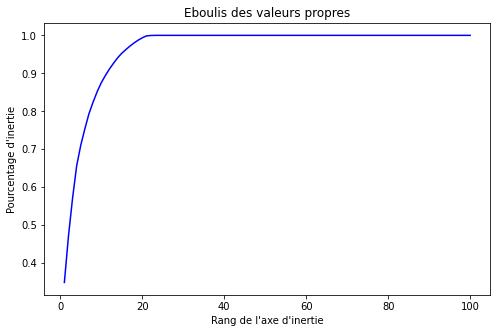

In [45]:
eVc = pca_model.explainedVariance.cumsum()
# plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eVc) + 1), eVc, color="b", linestyle="-")
plt.title("Eboulis des valeurs propres")
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")

## 20 first components

In [46]:
pca_obj = PCA(k=12, inputCol="data_scale", outputCol="pca_features_classic")
pca_model = pca_obj.fit(images_df)

22/05/18 23:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
22/05/18 23:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.8 KiB
22/05/18 23:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB
22/05/18 23:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1072.2 KiB
22/05/18 23:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1073.4 KiB


In [47]:
images_df = pca_model.transform(images_df)

In [48]:
images_df.show(6)

22/05/18 23:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1184.8 KiB


+--------------------+-------+--------------------+--------------------+
|                path|  categ|          data_scale|pca_features_classic|
+--------------------+-------+--------------------+--------------------+
|5_classes_5_image...|  Apple|[0.0,0.2000000000...|[-24.096101642763...|
|5_classes_5_image...|  Apple|[0.0,0.2000000000...|[-5.7505874019738...|
|5_classes_5_image...|  Apple|[0.0,-4.799999999...|[6.9212516552317,...|
|5_classes_5_image...|  Apple|[0.0,0.2000000000...|[-23.481750224938...|
|5_classes_5_image...|  Apple|[0.0,0.2000000000...|[3.56131454121887...|
|5_classes_5_image...|Avocado|[0.0,0.2000000000...|[-22.149714135642...|
+--------------------+-------+--------------------+--------------------+
only showing top 6 rows



In [49]:
images_df = images_df.drop("data_scale")

In [50]:
images_df.persist(pyspark.StorageLevel.DISK_ONLY)

DataFrame[path: string, categ: string, pca_features_classic: vector]

## VGG16 features extraction

In [51]:
from keras.preprocessing import image
from keras.models import Model
from keras import utils

2022-05-18 23:36:10.111730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 23:36:10.111766: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [52]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

In [53]:
def get_vgg16_features(path):
    try:
        virgin_vgg16 = VGG16()
    except:
        raise UDFException("Can't create virgin")

    try:
        model_vgg16 = Model(
            inputs=virgin_vgg16.inputs, outputs=virgin_vgg16.layers[-2].output
        )
    except:
        raise UDFException("can't make custom")

    try:
        s3 = session.resource("s3")
        bucket = s3.Bucket("p08oc")
        obj = bucket.Object(key=path)
        response = obj.get()
        file_stream = response["Body"]
    except:
        raise UDFException("can't read image")

    try:
        im = Image.open(file_stream)
        im = im.resize((224, 224))
        im = utils.img_to_array(im)
        im = im.reshape(1, 224, 224, 3)
        im = preprocess_input(im)
    except:
        raise UDFException("can't preprocess")

    try:
        features = model_vgg16.predict(im).ravel().tolist()
    except:
        raise UDFException("can't predict")

    return features

In [54]:
virgin_vgg16 = VGG16()

2022-05-18 23:36:11.466878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 23:36:11.466908: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 23:36:11.466929: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-27-176): /proc/driver/nvidia/version does not exist
2022-05-18 23:36:11.467105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
model_vgg16 = Model(inputs=virgin_vgg16.inputs, outputs=virgin_vgg16.layers[-2].output)

In [56]:
bucket = s3.Bucket("p08oc")
obj = bucket.Object(key="5_classes_5_images/Apple/2_100.jpg")
response = obj.get()
file_stream = response["Body"]

In [57]:
im = Image.open(file_stream)
im = im.resize((224, 224))
im = utils.img_to_array(im)
im = im.reshape(1, 224, 224, 3)
im = preprocess_input(im)

In [58]:
# im

In [59]:
features = model_vgg16.predict(im).ravel().tolist()

1/1 [==============================] - 0s 288ms/step


In [60]:
# features

In [61]:
udf_vgg_features = udf(get_vgg16_features)

In [62]:
images_df = images_df.withColumn("vgg_features", udf_vgg_features("path"))

In [63]:
# images_df

In [64]:
# images_df.show(3)

In [65]:
udf_vecto = udf(lambda r: Vectors.dense(r), VectorUDT())

In [66]:
images_df = images_df.withColumn("vgg_features", udf_vecto("vgg_features")).persist(
    pyspark.StorageLevel.DISK_ONLY
)

In [67]:
images_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- categ: string (nullable = true)
 |-- pca_features_classic: vector (nullable = true)
 |-- vgg_features: vector (nullable = true)



In [68]:
standardizer_vgg = StandardScaler(
    inputCol="vgg_features", outputCol="vgg_features_scale", withStd=True, withMean=True
)
model_std_vgg = standardizer_vgg.fit(images_df)
images_df = model_std_vgg.transform(images_df)

22/05/18 23:36:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
2022-05-18 23:36:19.870995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 23:36:19.871036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-18 23:36:21.345838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 23:36:21.345872: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 23:36:21.345893: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-27-176): /proc/driver/nvid

In [69]:
images_df = images_df.drop("vgg_features")

In [70]:
pca_obj = PCA(k=100, inputCol="vgg_features_scale")
pca_model = pca_obj.fit(images_df)

22/05/18 23:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:37:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:37:25 WARN BlockManager: Asked to remove block broadcast_29, which does not exist


Text(0, 0.5, "Pourcentage d'inertie")

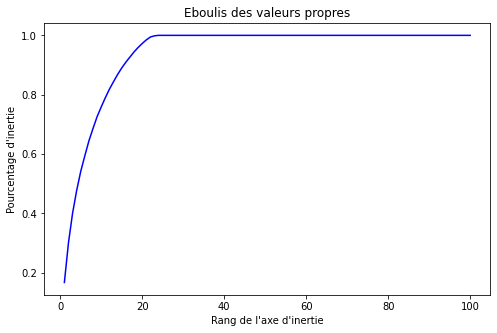

In [71]:
eVc = pca_model.explainedVariance.cumsum()
# plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eVc) + 1), eVc, color="b", linestyle="-")
plt.title("Eboulis des valeurs propres")
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")

## 24 first components

In [72]:
pca_obj = PCA(k=24, inputCol="vgg_features_scale", outputCol="pca_features_vgg")
pca_model = pca_obj.fit(images_df)

22/05/18 23:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/18 23:41:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [73]:
images_df = pca_model.transform(images_df).persist(pyspark.StorageLevel.DISK_ONLY)

## Pandas convertion

In [74]:
images_df_pandas = images_df.toPandas()

22/05/18 23:44:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


## S3 save

In [75]:
from io import StringIO

In [76]:
csv_obj = StringIO()
images_df_pandas.to_csv(csv_obj)
s3.Object("p08oc", "results/results_sample_cloud_1.csv").put(Body=csv_obj.getvalue())

{'ResponseMetadata': {'RequestId': '3FX5NKE8GPBNAJAB',
  'HostId': '0+7sMOi/W3jbGX0pF3BQTLpjd3ZMk2OaW8HdYfECsS5y7pN1YcRMz7VrIdLxHcOvhOYntmaQorM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '0+7sMOi/W3jbGX0pF3BQTLpjd3ZMk2OaW8HdYfECsS5y7pN1YcRMz7VrIdLxHcOvhOYntmaQorM=',
   'x-amz-request-id': '3FX5NKE8GPBNAJAB',
   'date': 'Wed, 18 May 2022 23:44:45 GMT',
   'etag': '"826f278c7a5f8b6766c386cd1580869a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"826f278c7a5f8b6766c386cd1580869a"'}

In [77]:
images_df_pandas.head(3)

,path,categ,pca_features_classic,vgg_features_scale,pca_features_vgg
0,5_classes_5_images/Apple/2_100.jpg,Apple,"[-24.096101642763358, 4.211594331273777, -4.80...","[0.0, 0.0, -0.53899685797527, -0.7864160630814...","[3.4186094085814522, 13.218795884746914, -6.42..."
1,5_classes_5_images/Apple/39_100.jpg,Apple,"[-5.750587401973896, 9.286614105569027, -1.202...","[0.0, 0.0, -0.53899685797527, 1.76184019034828...","[12.39954595401875, 24.783298732118396, -10.71..."
2,5_classes_5_images/Apple/4_100.jpg,Apple,"[6.9212516552317, 11.572283042078361, 12.38456...","[0.0, 0.0, -0.53899685797527, -0.3288515105482...","[9.836680579559298, 18.148467928235544, -3.906..."


In [78]:
sc.uiWebUrl

'http://ip-172-31-27-176.eu-west-3.compute.internal:4040'